<a href="https://colab.research.google.com/github/sina90alz/PyTorch-projects/blob/main/03_PyTorch_Computer_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import PyTorch
import torch
from torch import nn

# Import torchvision
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

# Import matplotlib for plotting
import matplotlib.pyplot as plt

# Check versions
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)

PyTorch version: 2.9.0+cu126
Torchvision version: 0.24.0+cu126


In [ ]:
# Setup training data
train_data = datasets.FashionMNIST(root="data", # where to download data to
                                   train=True, # get training data
                                   download=True, # download data if it does not exist on disk
                                   transform=ToTensor(), # images come as PIL format, we want to turn into Torch tensors
                                   target_transform=None # you can transform labels as well
                                    )


# Setup testing data
test_data = datasets.FashionMNIST(root="data", # where to download data to
                                   train=False, # get training data
                                   download=True, # download data if it does not exist on disk
                                   transform=ToTensor() # images come as PIL format, we want to turn into Torch tensors
                                  )

In [ ]:
image, label = train_data[0]
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

Text(0.5, 1.0, '9')

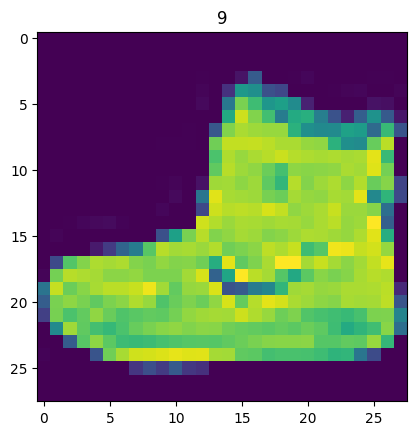

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(image.squeeze())
plt.title(label)

Text(0.5, 1.0, 'Ankle boot')

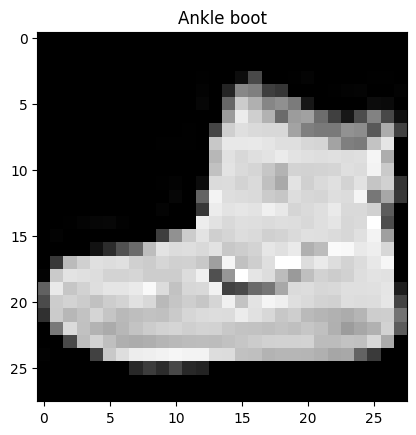

In [ ]:
plt.imshow(image.squeeze(), cmap="gray")
plt.title(class_names[label])

In [ ]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

# Turn datasets into iterables (batches)
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False) # no need to shuffle testing data

In [ ]:
# Create model
from torch import nn
class FashionMNISTModelV0(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
      super().__init__()
      self.layer_stack = nn.Sequential(
          nn.Flatten(), # input in vector
          nn.Linear(in_features=input_shape, out_features=hidden_units),
          nn.Linear(in_features=hidden_units, out_features=output_shape)
      )

    def forward(self, x):
      return self.layer_stack(x)

In [ ]:
model_0 = FashionMNISTModelV0(input_shape=784,
                              hidden_units=10,
                              output_shape=len(class_names))


In [ ]:
model_0

FashionMNISTModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [ ]:
import requests
from pathlib import Path

# Download helper functions from Learn Pytorch repo
if Path("helper_functions.py").is_file():
  print("Helper functions already downloaded")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

Helper functions already downloaded


In [ ]:
# Import accurancy metrci
from helper_functions import accuracy_fn

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

In [ ]:
class FashionMNistModelV1(nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
    super().__init__()
    self.layer_stack = nn.Sequential(
      nn.Flatten(),
      nn.Linear(in_features=input_shape, out_features=hidden_units),
      nn.ReLU(),
      nn.Linear(in_features=hidden_units, out_features=output_shape),
      nn.ReLU()
    )

  def forward(self, x):
    return self.layer_stack(x)

In [ ]:
torch.manual_seed(42)
model_1 = FashionMNistModelV1(input_shape=784,
                              hidden_units=10,
                              output_shape=len(class_names))

In [ ]:
from helper_functions import accuracy_fn
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.1)

In [ ]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn):
  train_loss, train_acc = 0, 0
  for batch, (X, y) in enumerate(dataloader):
    y_pred = model(X)

    loss = loss_fn(y_pred, y)
    train_loss += loss
    train_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  train_loss /= len(dataloader)
  train_acc /= len(dataloader)
  print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

In [ ]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data,
              loss_fn: torch.nn.Module,
              accuracy_fn):
  test_loss, test_acc = 0, 0
  model.eval()
  with torch.inference_mode():
    for X, y in dataloader:
      test_pred = model(X)

      test_loss += loss_fn(test_pred, y)
      test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))
    test_loss /= len(dataloader)
    test_acc /= len(dataloader)
  print(f"Train loss: {test_loss:.5f} | Train accuracy: {test_acc:.2f}%")

In [ ]:
from timeit import default_timer as timer
def print_train_time(start: float, end: float):
  total_time = end - start
  print(f"Total training time: {total_time:.3f} seconds")
  return total_time

## Model 2 : Building  Convolutional Neural Network

In [ ]:
# Create a CNN replicating TinyVGG architecture
class FashionMNISTModelV2(nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(
            in_channels=input_shape,
            out_channels=hidden_units,
            kernel_size=3,
            stride=1,
            padding=1
        ),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*7*7, out_features=output_shape)
    )
  def forward(self, x):
    x = self.conv_block_1(x)
    x = self.conv_block_2(x)
    x = self.classifier(x)
    return x

In [ ]:
torch.manual_seed(42)
model_2 = FashionMNISTModelV2(input_shape=1,
                              hidden_units=10,
                              output_shape=len(class_names))
model_2

FashionMNISTModelV2(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [ ]:
# Setup loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(), lr=0.1)

In [ ]:
from tqdm.auto import tqdm
from timeit import default_timer as timer
train_time_start_model_2 = timer()

# Train and test model
epochs = 3
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n-------")
  train_step(model=model_2,
              dataloader=train_dataloader,
              loss_fn=loss_fn,
             optimizer=optimizer,
             accuracy_fn=accuracy_fn)
##
  test_step(model=model_2,
            dataloader=test_dataloader,
            loss_fn=loss_fn,
            accuracy_fn=accuracy_fn)

train_time_end_model_2 = timer()
total_train_time_model_2 = print_train_time(train_time_start_model_2, train_time_end_model_2)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
-------
Train loss: 0.57716 | Train accuracy: 79.14%
Train loss: 0.39148 | Train accuracy: 85.90%
Epoch: 1
-------
Train loss: 0.35641 | Train accuracy: 87.20%
Train loss: 0.37143 | Train accuracy: 86.04%
Epoch: 2
-------
Train loss: 0.31685 | Train accuracy: 88.59%
Train loss: 0.33307 | Train accuracy: 87.75%
Total training time: 188.000 seconds


## Save Model

In [ ]:
from pathlib import Path

# Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "03_pytorch_computer_vision_model_v2.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

torch.save(obj=model_2.state_dict(), f=MODEL_SAVE_PATH)

# Reload Model

In [ ]:
loaded_model = FashionMNISTModelV2(input_shape=1,
                                   hidden_units=10,
                                   output_shape=len(class_names))

# Load in saved model
loaded_model.load_state_dict(torch.load(MODEL_SAVE_PATH))

<All keys matched successfully>

##Make prediction

In [ ]:
from tqdm.auto import tqdm
# 1. Make predictions with trained model
y_preds = []
loaded_model.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making predictions"):
    y_logit = loaded_model(X)
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)
    y_preds.append(y_pred)
  y_pred_tensor = torch.cat(y_preds)

Making predictions:   0%|          | 0/313 [00:00<?, ?it/s]

In [ ]:
# See if torchmetrics exists, if n ot, install it
try:
  import torchmetrics, mlxtend
  assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend version must be at least 0.19.0"
except:
  !pip install -q torchmetrics -U mlxtend
  import torchmetrics, mlxtend
  print(f"mlxtend version: {mlxtend.__version__}")

##Create Confusion matrix

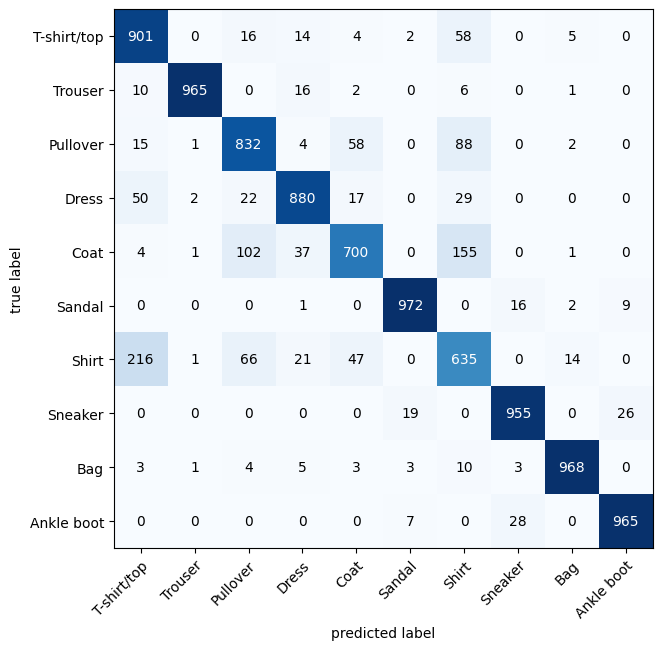

In [ ]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. Setup confusion matrix instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor, target=test_data.targets)

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy
                                class_names=class_names, # turn the row and column labels into class names
                                figsize=(10, 7))